In [1]:
import numpy as np
import gpstk
from Toolkit_GNSS import *
import matplotlib.pyplot as plt
%matplotlib inline

##Stations

In [2]:
#Station 1 Rinex Files, Station 2 Rinex Files, PRN Satellite
station=[["/mnt/zob1324.03.n","/mnt/zob1324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 8"]


# Step 1) Get observations Data (Carrier Phase, Code, Times, etc.)

In [3]:
st1,st2,satellite=station[0],station[1],station[2]
t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2,L11,L12,L21,L22,C11,C12,C21,C22,Tgd =getdata_stationpair(st1,st2,satellite)

In [4]:
print type(t1),type(Icode1),type(Iphase1)

<type 'list'> <type 'dict'> <type 'dict'>


#Step 2) Separate into arcs

Observations separated for more than an hour it's sonsidered a new arc. So the information is divided: **carrier phase, code, elevation and IPP's. **

In [5]:
def get_arcs(t,Icode,Iphase,ELEV,IPPS,L1,L2,C1,C2): 
    #Returns arcs with observations time, phase & code delay,IPP
    #For every station returns a dictionary
    ##key: Number of arc observed in that day (starting with 0).
    ##values: Phase, Code, etc in that arc
    Phase,Code,Elevation=[],[],[]
    PhaseL1,PhaseL2=[],[]
    CodeL1,CodeL2,IPP=[],[],[]
    notfound=0 
    a=[]
    
    for i in t:
        if i in Iphase.keys(): #all times in t should correspond to the keys in the dictionaries.
            Phase.append(Iphase[i])
            Code.append(Icode[i])
            Elevation.append(ELEV[i])
            PhaseL1.append(L1[i])
            PhaseL2.append(L2[i])
            CodeL1.append(C1[i])
            CodeL2.append(C2[i])
            IPP.append(IPPS[i])
        else:
            #print "Tiempo no encontrado: ",i
            notfound+=1
            
    if notfound>0:
        print "Tiempos no encontrados :",notfound
    
    t=adjust_times(t)
    
    Phase,Code,t,Elevation,PhaseL1,PhaseL2,CodeL1,CodeL2=np.array(Phase),np.array(Code),np.array(t),np.array(Elevation),np.array(PhaseL1),np.array(PhaseL2),np.array(CodeL1),np.array(CodeL2)
    
    limits=[]
    for i in range(1,len(t)):
        if t[i]-t[i-1]>3600: 
            limits.append(i)

    arcs=np.split(range(t.size),limits)
    obs={} #Key: Number arc, Values: array time of observations , arrayPhase Delays, array code etc.
    i=0
    for arc in arcs:
        obs[i]=[t[arc],Phase[arc],Code[arc],Elevation[arc],PhaseL1[arc],PhaseL2[arc],CodeL1[arc],CodeL2[arc]]
        i+=1
    return obs

In [6]:
arcs_St1=get_arcs(t1,Icode1,Iphase1,ELEV1,IPP1,L11,L12,C11,C12) #gets arcs with Phase, Code, and adjusted times observations
arcs_St2=get_arcs(t2,Icode2,Iphase2,ELEV2,IPP2,L21,L22,C21,C22)
len(arcs_St1),len(arcs_St2)

(2, 2)

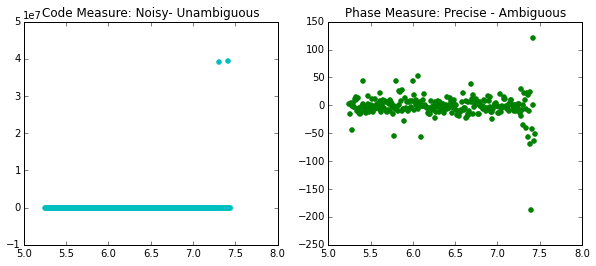

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Code Measure: Noisy- Unambiguous")
plt.scatter(arcs_St1[0][0]/3600,arcs_St1[0][1],color="c")
plt.subplot(1,2,2)
plt.title("Phase Measure: Precise - Ambiguous")
plt.scatter(arcs_St1[0][0]/3600,arcs_St1[0][2],color="g")

#Step 3) Cycle slip detection for 1 arc
On days with strong ionospheric activity the threshold is more flexible (bigger) 2.5 meters, that way we avoid confusing gradients with cycle slips

In [9]:
arc=1 #second 
if arc in arcs_St1 and arc in arcs_St2:
    print "\n*************Arc #"+str(arc+1)+"*************"
    time1=arcs_St1[arc][0] 
    time2=arcs_St2[arc][0] 

    tboth=np.intersect1d(time1,time2)
    print "\n# Times in common: ",tboth.size
    
    #Now we take observations in both stations
    t1index=np.array([i for i in range(time1.size) if time1[i] in tboth ])
    t2index=np.array([i for i in range(time2.size) if time2[i] in tboth ])
    print "IndexT1 type",type(t1index)
    print t1index.shape

    time1,time2=time1[t1index],time2[t2index]
    Phase1,Phase2=arcs_St1[arc][1][t1index],arcs_St2[arc][1][t2index]
    Code1,Code2=arcs_St1[arc][2][t1index],arcs_St2[arc][2][t2index]
    Elevation1,Elevation2=arcs_St1[arc][3][t1index],arcs_St2[arc][3][t2index]

    #Phase on frequency L1,L2 station1
    Phase1L1,Phase1L2=arcs_St1[arc][4][t1index],arcs_St1[arc][5][t1index]
    Code1L1,Code1L2=arcs_St1[arc][6][t1index],arcs_St1[arc][7][t1index]

    #Phase and Code on frequency L1,L2 station 2
    Phase2L1,Phase2L2=arcs_St2[arc][4][t2index],arcs_St2[arc][5][t2index]
    Code2L1,Code2L2=arcs_St2[arc][6][t2index],arcs_St2[arc][7][t2index]
   
    #Ionospheric pearce points
    DIPP1=getIPPS(IPP1,tboth)
    DIPP2=getIPPS(IPP2,tboth)
    
    D=[]
    for i in tboth:
        d=np.sqrt((DIPP1[i][0]-DIPP2[i][0])**2+(DIPP1[i][1]-DIPP2[i][1])**2+(DIPP1[i][2]-DIPP2[i][2])**2)
        D.append(d)

    D=np.array(D)
  


*************Arc #2*************

# Times in common:  632
IndexT1 type <type 'numpy.ndarray'>
(632,)


In [10]:
def datajump(lI,threshold=0.5): #Input: lI=L1-L2, times. Detects jumps in data depending on a threshold
    jumps=[]
    jumps=np.where(np.abs(np.diff(np.hstack(([0],lI))))>threshold) 
    return jumps[0] 
    

In [11]:
jumps1=datajump(Phase1,2.5)
jumps2=datajump(Phase2,2.5)


In [12]:
jumps1

array([  0, 148, 168, 169, 177, 179, 375, 376, 377, 378])

In [21]:
def plot_slip(jumps,phase,time,jumpsMP=None):
    timejumps=time[jumps]
    phasejumps=phase[jumps]
    plt.figure()
    plt.scatter(time,phase,color="yellow" ,label="Normal points") #points
    plt.scatter(timejumps,phasejumps,color="#ff3300",label="Jumps")
    if jumpsMP!=None and len(jumpsMP)>0:
        timeMP=time[jumpsMP]
        phaseMP=phase[jumpsMP]
        plt.scatter(timeMP,phaseMP,color="red",label="Multipass Jumps") #points of MP cycle slip
    plt.legend()
    plt.xlabel("Time [second of the day]")
    plt.ylabel("Phase delay in one station [meters]")
    plt.ylim(-300,100) #there is a huge cycle slip in this specific arc, this makes apreciate detail jumps

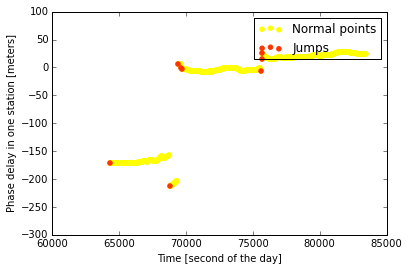

In [22]:
plot_slip(jumps1,Phase1,time1,jumpsMP=None)

##Step 3.1) In adition multipass slips can be detected

In [23]:
   
def MP_Slips(jumps1,jumps2,Code1L1,Code1L2,Phase1L1,Phase1L2,Code2L1,Code2L2,Phase2L1,Phase2L2):
    gamma=gpstk.GAMMA_GPS
    
    #MP1 & MP2 In station 1 if MP slips are not in jumps, they are added
    MP11=Code1L1-(1+(2/(gamma-1)))*Phase1L1 + (2/(gamma-1))*Phase1L2
    MP12=Code1L2-((2*gamma*Phase1L1)/(gamma-1))+(((2*gamma)/(gamma-1))-1)*Phase1L2
    jumpsMP11=datajump(MP11,threshold=10)
    jumpsMP12=datajump(MP12,threshold=10)

    #Add multipass slips to cycle slips
    Mp1,Mp2=np.array([]),np.array([]) #this is just for plotting
    for i in jumpsMP11:
        if i not in jumps1:
            jumps1=np.append(jumps1,i)
            jumps1=np.sort(jumps1)
            Mp1=np.append(Mp1,int(i))

    for i in jumpsMP12:
        if i not in jumps1:
            jumps1=np.append(jumps1,i)
            jumps1=np.sort(jumps1)
            Mp1=np.append(Mp1,int(i))

    #MP1 & MP2 In station 2
    MP21=Code2L1-(1+(2/(gamma-1)))*Phase2L1 + (2/(gamma-1))*Phase2L2
    MP22=Code2L2-((2*gamma*Phase2L1)/(gamma-1))+(((2*gamma)/(gamma-1))-1)*Phase2L2
    jumpsMP21=datajump(MP21,threshold=10)
    jumpsMP22=datajump(MP22,threshold=10)


    for i in jumpsMP21:
        if i not in jumps2:
            jumps2=np.append(jumps2,i)
            jumps2=np.sort(jumps2)
            Mp2=np.append(Mp2,int(i))

    for i in jumpsMP22:
        if i not in jumps2:
            jumps2=np.append(jumps2,i)
            jumps2=np.sort(jumps2)
            Mp2=np.append(Mp2,int(i))
    
    return jumps1,jumps2,Mp1,Mp2



In [24]:
jumps1wMP,jumps2wMP,Mp1,Mp2=MP_Slips(jumps1,jumps2,Code1L1,Code1L2,Phase1L1,Phase1L2,Code2L1,Code2L2,Phase2L1,Phase2L2)

In [25]:
Mp1

array([   3.,    4.,    5.,    6.,    8.,   10.,   20.,   21.,   22.,
         23.,   25.,   43.,   44.,  180.,  622.,  623.,  624.,  625.])

In [18]:
jumps1wMP

array([  0,   3,   4,   5,   6,   8,  10,  20,  21,  22,  23,  25,  43,
        44, 148, 168, 169, 177, 179, 180, 375, 376, 377, 378, 622, 623,
       624, 625])

/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


IndexError: arrays used as indices must be of integer (or boolean) type

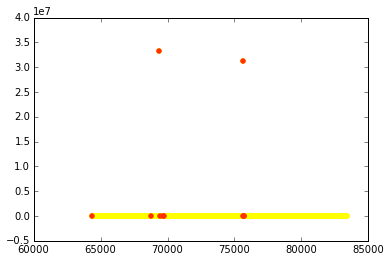

In [19]:
plot_slip(jumps1,Phase1,time1,jumpsMP=Mp1)